In [1]:
#pip install --user git+https://github.com/brazil-data-cube/EOCubes@master --upgrade --no-cache-dir

In [2]:
### Import eocubes ###
from bdc_eocubes.business import Business as eocubes

In [3]:
### List cubes ###
cubes = eocubes.list_cubes()
cubes

{'S1016d:MEDIAN': 'localhost:5051/describe_cube?name=S1016d:MEDIAN',
 'S1016d:STACK': 'localhost:5051/describe_cube?name=S1016d:STACK',
 'HLS_S30_MGRS_16d:MEDIAN': 'localhost:5051/describe_cube?name=HLS_S30_MGRS_16d:MEDIAN',
 'HLS_S30_MGRS_16d:STACK': 'localhost:5051/describe_cube?name=HLS_S30_MGRS_16d:STACK',
 'C6416d:MEDIAN': 'localhost:5051/describe_cube?name=C6416d:MEDIAN',
 'C6416d:STACK': 'localhost:5051/describe_cube?name=C6416d:STACK',
 'S10m:MEDIAN': 'localhost:5051/describe_cube?name=S10m:MEDIAN',
 'S10m:STACK': 'localhost:5051/describe_cube?name=S10m:STACK'}

In [4]:
### Get cube description ###
cube_s10 = eocubes.describe_cube('S10m:STACK')
cube_s10

{'name': 'S10m',
 'description': 'S10m datacube with products from S2SR(Sattelite/Sensor) with coastal,blue,green,red,redge1,redge2,redge3,nir,bnir,swir1,swir2,ndvi,evi,quality bands.',
 'crs': '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
 'bbox': ['-13.2415', '-67.1244', '-45.0463', '-3.54103'],
 'bands': ['coastal',
  'blue',
  'green',
  'red',
  'redge1',
  'redge2',
  'redge3',
  'nir',
  'bnir',
  'swir1',
  'swir2',
  'ndvi',
  'evi',
  'quality'],
 'tiles': ['076095', '078094', '085089', '089098']}

In [5]:
### get cube ###
my_cube = eocubes.get_cube('S10m:STACK', bbox= '-46.62597656250001,-13.19716452328198,-45.03570556640626,-12.297068292853805')
my_cube

{'2018-09-01/2019-08-01': {'timeline': ['2018-09-01T00:00:00',
   '2019-03-01T00:00:00',
   '2019-07-01T00:00:00',
   '2019-02-01T00:00:00',
   '2019-05-01T00:00:00',
   '2019-06-01T00:00:00',
   '2019-01-01T00:00:00',
   '2018-10-01T00:00:00',
   '2018-12-01T00:00:00',
   '2019-04-01T00:00:00',
   '2018-11-01T00:00:00',
   '2019-08-01T00:00:00'],
  'tiles': {'089098': {'bands': {'coastal': ['http://brazildatacube.dpi.inpe.br/bdc-stac/Repository/Mosaic/S10m/089098/2018-09-01-2018-09-30/S10m_089098_2018-09-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/bdc-stac/Repository/Mosaic/S10m/089098/2019-03-01-2019-03-31/S10m_089098_2019-03-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/bdc-stac/Repository/Mosaic/S10m/089098/2019-07-01-2019-07-31/S10m_089098_2019-07-01_coastal_STACK.tif',
      'http://brazildatacube.dpi.inpe.br/bdc-stac/Repository/Mosaic/S10m/089098/2019-02-01-2019-02-28/S10m_089098_2019-02-01_coastal_STACK.tif',
      'http://brazildatacube.dp

In [6]:
bands = my_cube['2018-09-01/2019-08-01']['tiles']['089098']['bands'].keys()
print( bands )

dict_keys(['coastal', 'blue', 'green', 'red', 'redge1', 'redge2', 'redge3', 'nir', 'bnir', 'swir1', 'swir2', 'ndvi', 'evi'])


In [7]:
links_nir = my_cube['2018-09-01/2019-08-01']['tiles']['089098']['bands']['nir']

In [8]:
#### Import Libs ####
import numpy

from matplotlib import pyplot as plt
from osgeo import gdal, osr

In [9]:
def open_remote(url):
        """GDAL Open Remotely"""
        data_set = gdal.Open('/vsicurl/{}'.format(url))

        return data_set

def transform_latlong_to_rowcol(data_set, lat, long):
    """Transforms a lat/long to GRID column"""
    srs = osr.SpatialReference()
    srs.ImportFromWkt(data_set.GetProjection())

    srs_lat_ong = srs.CloneGeogCS()
    ct = osr.CoordinateTransformation(srs_lat_ong, srs)
    x, y, _ = ct.TransformPoint(long, lat)

    transform = data_set.GetGeoTransform()

    x = int((x - transform[0]) / transform[1])
    y = int((transform[3] - y) / -transform[5])

    return x, y

def get_raster_blocks(data_set, blocks, block_size=None):
        """
        Retrieve the Data Set from GDAL Raster blocks
        Args:
            data_set (gdal.Dataset) - An opened GDAL dataset
            blocks (list of tuples) - List of block positions to retrieve
            block_size (list) - Block X and Block Y values. Default is native
        Returns:
            numpy.Array Sliced array
        """
        band = data_set.GetRasterBand(1)

        if not block_size:
            block_size = band.GetBlockSize()

        block_x, block_y = block_size

        raster_blocks = []

        for block in blocks:
            x, y = block

            offset_x = x * block_x
            offset_y = y * block_y

            if offset_x + block_x < band.XSize:
                cols = block_x
            else:
                cols = offset_x - offset_x

            if offset_y + block_y < band.YSize:
                rows = block_y
            else:
                rows = band.YSize - offset_y

            raster_blocks.append(
                band.ReadAsArray(offset_x, offset_y, cols, rows))

        return raster_blocks

def build_bbox(w,n,e,s):
    """
    Build a bounding box using lat long west, north, east and south coordinates:
        w (integer) - West Coordinate
        n (integer) - North Coordinate
        e (integer) - East Coordinate
        s (integer) - South Coordinate
    Returns:
        tuple bbox
    """
    bbox = ( (w,n), (e,s) )
    return( bbox )



def long_lat_block( data_set, longlat ):
    """
    Retrieve a block iven a longitude and latitude. Args:
        longlat (integer tuple) - A coordinate tuples
        data_set (gdal.Dataset) - An opened GDAL dataset
    Returns:
        tuple long_lat_block
    """
    x = longlat[0]
    y = longlat[1]
    band = data_set.GetRasterBand(1)
    block_x, block_y = band.GetBlockSize()

    x_size, y_size = band.XSize, band.YSize

    long_block = x // block_x
    lat_block = y // block_y

    long_lat_block = (
        long_block if long_block > -1 else \
            long_block - ceil(x_size / block_x),
        lat_block if lat_block > -1 else \
            lat_block - - ceil(y_size / block_y)
    )  
    
    return long_lat_block

def get_bbox_blocks( data_set, bbox ):
    """
    Retrieve all pairs of blocks given a bounding box. Args:
        bbox (tuple of integer tuple)- Bounding box, tuple containing upper left and botom right coordinate tuples
        data_set (gdal.Dataset) - An opened GDAL dataset
    Returns:
        list lst_block_pairs
    """
    import itertools
    bbox_row_col = (transform_latlong_to_rowcol(data_set, bbox[0][0],bbox[0][1]),
                    transform_latlong_to_rowcol(data_set, bbox[1][0],bbox[1][1]) )

    coord_start_block = long_lat_block( data_set, bbox_row_col[0] )
    if type(coord_start_block)!=list:
        coord_start_block = [coord_start_block]
    coord_end_block = long_lat_block( data_set, bbox_row_col[1] )
    if type(coord_end_block)!=list:
        coord_end_block = [coord_end_block]
        
    ### Get all block pairs ###
    blocks_coord_a = list( range(coord_start_block[0][0],coord_end_block[0][0]+1) )
    blocks_coord_b = list( range(coord_start_block[0][1],coord_end_block[0][1]+1) )
    lst_block_pairs = list(itertools.product(blocks_coord_a, blocks_coord_b) )
    
    return lst_block_pairs


def blocks_to_matrix(data_set, blocks):
    """
    Retrieve matrix values given GDAL Raster blocks
    Args:
        data_set (gdal.Dataset) - An opened GDAL dataset
        blocks (list of tuples) - List of block positions to retrieve
    Returns:
        numpy.Array mat
    """
    
    a = list(map(min, zip(*blocks)))
    b = list(map(max, zip(*blocks))) 
    
    print(a,b)
    
    dim_a = list( range(a[0],b[0]+1))
    dim_b = list( range(a[1],b[1]+1))
    
    block_x, block_y = data_set.GetRasterBand(1).GetBlockSize()

    ### Create empty matrix ###
    mat = numpy.zeros( (len(dim_b)*block_y, len(dim_a)*block_x) )
    print( len(dim_b), len(dim_a) )

    raster_blocks = get_raster_blocks(data_set, blocks)

    ### Populate matrix ###
    cont = 0
    for x in dim_a:
        for y in dim_b:
            mat[ (y-dim_b[0])*block_y : (y-dim_b[0])*block_y+block_y , (x-dim_a[0])*block_x : (x-dim_a[0])*block_x+block_x] += raster_blocks[cont]
            cont += 1
    return mat

In [10]:
filename_nir = 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-01-01-2019-01-31/S10m_089098_2019-01-01_nir_STACK.tif'

In [11]:
### Open ENTIRE nir band
try:
  ds_nir = open_remote(filename_nir)
  print ("Opened {}!".format(filename_nir))
except:
  print("Error opening file {}".format(filename_nir) )

Opened http://brazildatacube.dpi.inpe.br/Repository/Mosaic/S10m/089098/2019-01-01-2019-01-31/S10m_089098_2019-01-01_nir_STACK.tif!


Array size: (11723, 15737)
min value:0 max value:13274


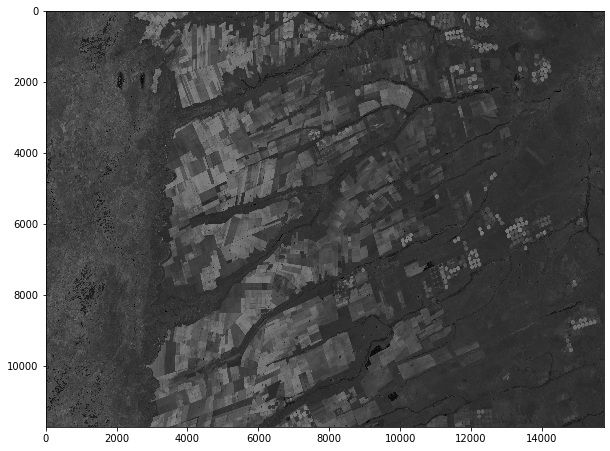

In [12]:
img_nir   = ds_nir.GetRasterBand(1).ReadAsArray()
print('Array size: {}'.format(img_nir.shape) )
print('min value:{} max value:{}'.format( numpy.nanmin(img_nir[img_nir != -numpy.inf]) , numpy.nanmax(img_nir) ))

### Plot image
plt.figure(figsize=(10, 10))
plt.imshow(img_nir,cmap = 'gray')
plt.show()

In [13]:
### Open blocks ###
ds = open_remote(filename_nir)
band = ds.GetRasterBand(1)

In [14]:
### CREATING BBOX ###
w = -45.90
n = -12.6
# e = -45.80
e = -45.40
# s = -12.74
s = -12.90

In [15]:
bbox = build_bbox(w,n,e,s)
print( bbox )

((-45.9, -12.6), (-45.4, -12.9))


In [16]:
bbox_blocks = get_bbox_blocks( ds, bbox )
# print( bbox_blocks )

In [17]:
img = blocks_to_matrix(ds, bbox_blocks)

[28, 15] [47, 30]
16 20


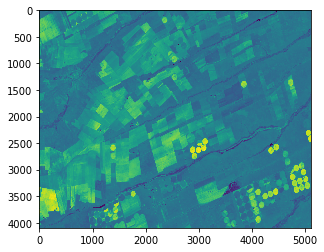

In [18]:
plt.imshow(img)
plt.show()

In [19]:
### Open several bands ###

In [20]:
print( bands )

dict_keys(['coastal', 'blue', 'green', 'red', 'redge1', 'redge2', 'redge3', 'nir', 'bnir', 'swir1', 'swir2', 'ndvi', 'evi'])


In [24]:
### select a few bands
my_bands = ('blue', 'green', 'red', 'nir')
my_bands

('blue', 'green', 'red', 'nir')

In [26]:
for band in my_bands:
    print( band )
    #load bands to xarray

blue
green
red
nir
